# Input data Preparation

Since the investor does not know the value of the expected return $\mu$ and the covariance matrix $\Sigma$, we need to find estimate of those values. 

In a stochastic environment a rational approach should link the maket model, i.e the distribution of the prices at the investment horizion, with the observations, i.e. the past realizations of some market observables. 

The job of the inverstion is to project those past observations into future distributions.

## Detecting invariants

The process to achieve the goal describe above is based on the concept of **invariant**.

The market displays some phenomena that repeats themselves identically throughout history: those phenomena are called invariants.

Due to the repetitive behavior of the market invariants, it is possible by means of statistical porcedure to infer their distribution.

And then this estimated distribution need to be projected to the generic investment horizon $\tau$ that is relevant to the investor.

In the case of the stock market those invariants are the compounded returns (or logaritmic returns). The compounded return at time $t$ for a horizon $\tau$ is defined as follows: 

$$
C_{t, \tau} = \ln \left( \frac{P_t}{P_{t - \tau}} \right)
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

close_df = pd.read_csv('..\data\DK\preprocessed_data\danish_closed_stocks.csv', index_col=0)
close_df = close_df.fillna(method='bfill')
close_df.index = pd.to_datetime(close_df.index)

stock_names = close_df.columns

Let's start by calculating the weekly prices

In [2]:
df_weekly_prices = close_df.resample('W').last()

Next we compute the weekly logarithmic return from the weekly prices. 

In [3]:
df_weekly_log_returns = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
df_weekly_log_returns = df_weekly_log_returns.dropna(how='all')
df_weekly_log_returns = df_weekly_log_returns.fillna(0)

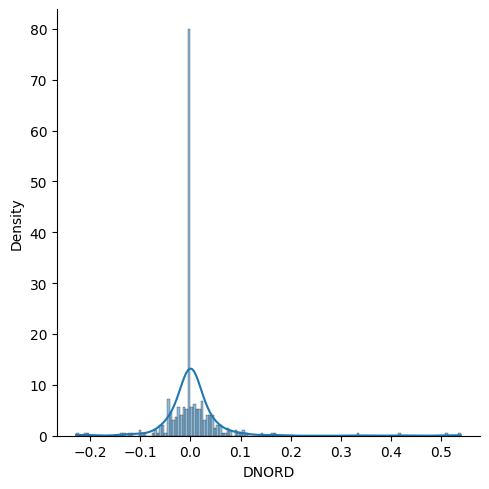

In [4]:
sns.displot(df_weekly_log_returns, x="DNORD", kde=True, stat="density")
plt.show()

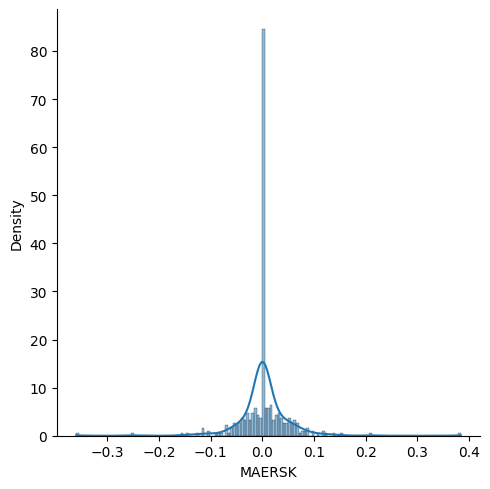

In [5]:
sns.displot(df_weekly_log_returns, x="MAERSK", kde=True, stat="density")
plt.show()

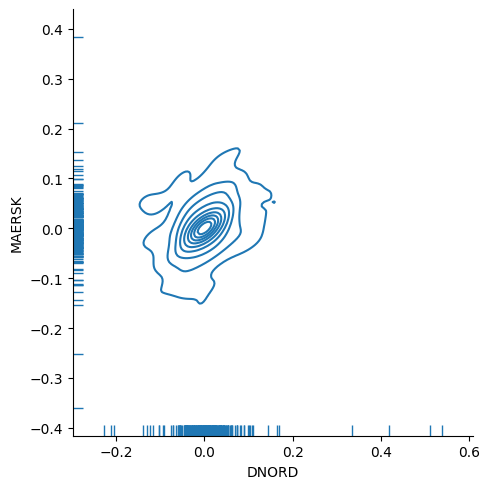

In [6]:
sns.displot(
    df_weekly_log_returns, x="DNORD", y="MAERSK",
    kind="kde", rug=True
)

plt.show()

Assuming that the weekly compounded are normally distributed, that means that we have to estimate the parameters $\mu_{\tau}^{\log}$ and $\Sigma_{\tau}^{\log}$ of the distribution. In our case this is simply done by calculating the mean and the covariance of the weekly returns calculated before. 

In [7]:
return_array = df_weekly_log_returns.to_numpy()
m_weekly_log = np.mean(return_array, axis=0)
S_weekly_log = np.cov(return_array.transpose())

Since in our case the investment horizon is 1 year, we have to project the distribution of weekly logarithmic returns to one year investment horizon. Since logarithmic return are additive across time, the projected distribution will also be normal with parameters 

$$
\mu_h^{\log} = \frac{h}{\tau} \mu_{\tau}^{\log}, \Sigma_h^{\log} = \frac{h}{\tau} \Sigma_{\tau}^{\log} 
$$

In [8]:
m_log = 52 * m_weekly_log
S_log = 52 * S_weekly_log

To calculate the distribution of linear returns at the investment horizon $h$, we begin by determining the distribution of security prices at that horizon. This can be achieved using the characteristic function of the normal distribution and the pricing function $P_h = p_o \exp(R^{\log})$,

$$
\begin{split}\begin{array}{lcr}
\mathbb{E}(P_h)   & = & \mathbf{p}_0 \circ \mathrm{exp}\left(\mu_h^\mathrm{log} + \frac{1}{2}\mathrm{diag}(\Sigma_h^\mathrm{log})\right), \\
\mathrm{Cov}(P_h) & = & \mathbb{E}(P_h)\mathbb{E}(P_h)^\mathsf{T} \circ (\mathrm{exp}(\Sigma_h^\mathrm{log}) - 1).
\end{array}\end{split}
$$

In [9]:
p_0 = df_weekly_prices.iloc[0].to_numpy()
m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)

Then the estimated moments of the linear return is easy to get by $\mu = \frac{1}{p_0} \circ \mathbb{E}(P_h) - 1$ and $\Sigma = \frac{1}{p_0 p_0^T} \circ Cov(P_h)$

In [10]:
m = 1 / p_0 * m_P - 1
S = 1 / np.outer(p_0, p_0) * S_P

In [12]:
# Save m and S to some files 
np.save('../data/DK/preprocessed_data/stocks/m_log.npy', m_log)
np.save('../data/DK/preprocessed_data/stocks/S_log.npy', S_log)
np.save('../data/DK/preprocessed_data/stocks/m.npy', m)
np.save('../data/DK/preprocessed_data/stocks/S.npy', S)